# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [31]:
from sklearn.datasets import load_files 
from sklearn.metrics import classification_report
from keras.utils import np_utils
import numpy as np
from glob import glob

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image                  

from tqdm import tqdm

from PIL import ImageFile

from extract_bottleneck_features import *

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
dog_names

['ages/train/001.Affenpinscher',
 'ages/train/002.Afghan_hound',
 'ages/train/003.Airedale_terrier',
 'ages/train/004.Akita',
 'ages/train/005.Alaskan_malamute',
 'ages/train/006.American_eskimo_dog',
 'ages/train/007.American_foxhound',
 'ages/train/008.American_staffordshire_terrier',
 'ages/train/009.American_water_spaniel',
 'ages/train/010.Anatolian_shepherd_dog',
 'ages/train/011.Australian_cattle_dog',
 'ages/train/012.Australian_shepherd',
 'ages/train/013.Australian_terrier',
 'ages/train/014.Basenji',
 'ages/train/015.Basset_hound',
 'ages/train/016.Beagle',
 'ages/train/017.Bearded_collie',
 'ages/train/018.Beauceron',
 'ages/train/019.Bedlington_terrier',
 'ages/train/020.Belgian_malinois',
 'ages/train/021.Belgian_sheepdog',
 'ages/train/022.Belgian_tervuren',
 'ages/train/023.Bernese_mountain_dog',
 'ages/train/024.Bichon_frise',
 'ages/train/025.Black_and_tan_coonhound',
 'ages/train/026.Black_russian_terrier',
 'ages/train/027.Bloodhound',
 'ages/train/028.Bluetick_coon

In [4]:
#remove not useful information from dog_names ages/train/
short_dog_names = []
i = 0
for names in dog_names:
    i+=1
    names = names.replace('ages/train/','')
    print(names)
    short_dog_names.append(names)
    if i > 133 : break

001.Affenpinscher
002.Afghan_hound
003.Airedale_terrier
004.Akita
005.Alaskan_malamute
006.American_eskimo_dog
007.American_foxhound
008.American_staffordshire_terrier
009.American_water_spaniel
010.Anatolian_shepherd_dog
011.Australian_cattle_dog
012.Australian_shepherd
013.Australian_terrier
014.Basenji
015.Basset_hound
016.Beagle
017.Bearded_collie
018.Beauceron
019.Bedlington_terrier
020.Belgian_malinois
021.Belgian_sheepdog
022.Belgian_tervuren
023.Bernese_mountain_dog
024.Bichon_frise
025.Black_and_tan_coonhound
026.Black_russian_terrier
027.Bloodhound
028.Bluetick_coonhound
029.Border_collie
030.Border_terrier
031.Borzoi
032.Boston_terrier
033.Bouvier_des_flandres
034.Boxer
035.Boykin_spaniel
036.Briard
037.Brittany
038.Brussels_griffon
039.Bull_terrier
040.Bulldog
041.Bullmastiff
042.Cairn_terrier
043.Canaan_dog
044.Cane_corso
045.Cardigan_welsh_corgi
046.Cavalier_king_charles_spaniel
047.Chesapeake_bay_retriever
048.Chihuahua
049.Chinese_crested
050.Chinese_shar-pei
051.Chow_c

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [6]:
human_files[1]

'../../../data/lfw/JC_Chasez/JC_Chasez_0001.jpg'

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [7]:
def detect_and_box_faces(image_link, detect=True, box_thick=5):
    '''
    take an image link as an input
    detect parameter to identify and print number of faces detected
    plot the image with blue box around faces detected
    
    '''
    img = cv2.imread(image_link)

    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    if detect :
        faces = face_cascade.detectMultiScale(gray)

        # print number of faces detected in the image
        print('Number of faces detected:', len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,120,120),box_thick)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

Number of faces detected: 1


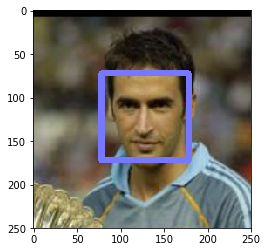

In [8]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

detect_and_box_faces(human_files[131])



Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [9]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [10]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def face_detector_performance(image_set):
    '''
    give the performance of face_detector for an image set
    take an image set as an input
    give a percent as an output
    '''
    
    # count face numbers
    image_count=0
    for img_s in image_set:
        if face_detector(img_s) == True:
            image_count+=1
    
    # calcul performance
    performance = (float(image_count)/float(len(image_set)))*100
    
    # express performance 
    print('Percent of faces detected is: {:3.2f}%'.format(performance))

In [11]:
# face detector performance on human_files_short
face_detector_performance(human_files_short)

Percent of faces detected is: 100.00%


In [12]:
# face detector performance on dog_files_short
face_detector_performance(dog_files_short)

Percent of faces detected is: 11.00%


image reference is ../../../data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg


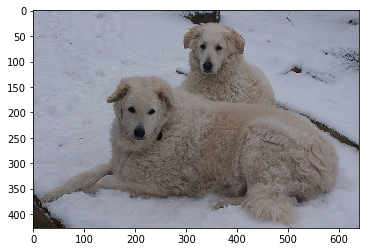

image reference is ../../../data/dog_images/train/099.Lhasa_apso/Lhasa_apso_06646.jpg


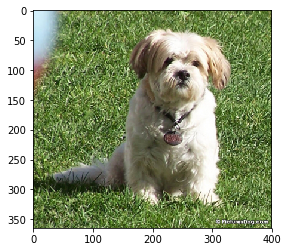

image reference is ../../../data/dog_images/train/009.American_water_spaniel/American_water_spaniel_00628.jpg


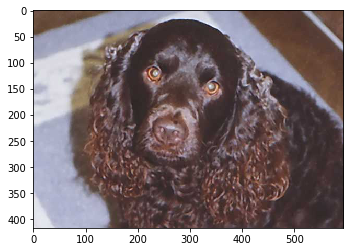

image reference is ../../../data/dog_images/train/057.Dalmatian/Dalmatian_04023.jpg


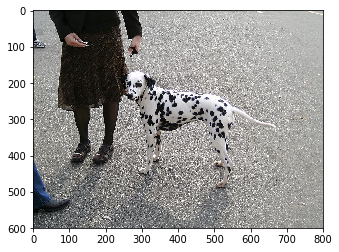

image reference is ../../../data/dog_images/train/096.Labrador_retriever/Labrador_retriever_06474.jpg


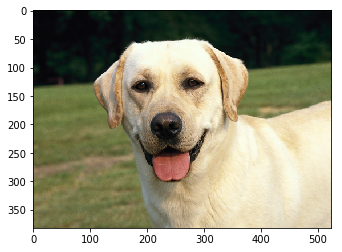

image reference is ../../../data/dog_images/train/106.Newfoundland/Newfoundland_06989.jpg


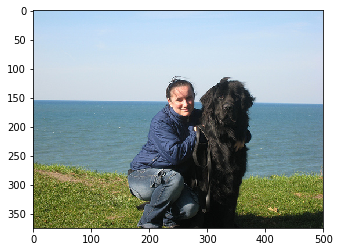

image reference is ../../../data/dog_images/train/117.Pekingese/Pekingese_07559.jpg


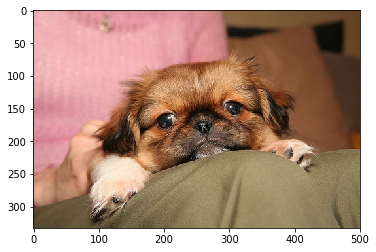

image reference is ../../../data/dog_images/train/039.Bull_terrier/Bull_terrier_02805.jpg


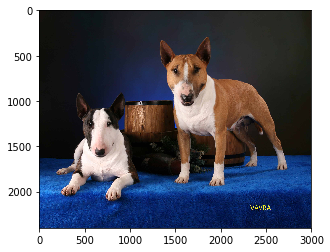

image reference is ../../../data/dog_images/train/097.Lakeland_terrier/Lakeland_terrier_06516.jpg


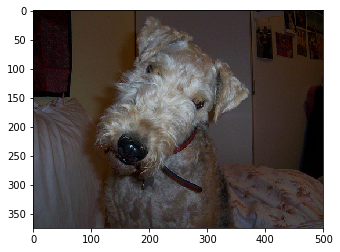

image reference is ../../../data/dog_images/train/024.Bichon_frise/Bichon_frise_01771.jpg


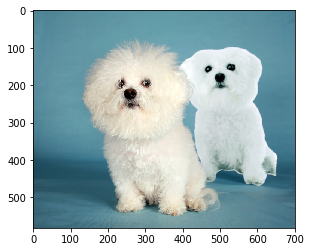

image reference is ../../../data/dog_images/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05705.jpg


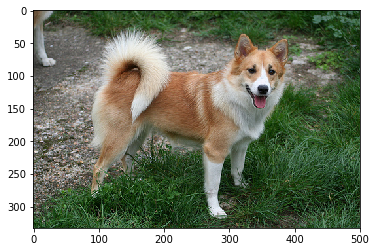

In [30]:
# observe image with faces detected in dog_files_short
dog_human_faces = []
for dog_f in dog_files_short:
    if face_detector(dog_f)==True:
        img = cv2.imread(dog_f)
        print('image reference is', dog_f)
        dog_human_faces.append(dog_f)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

Number of faces detected: 1


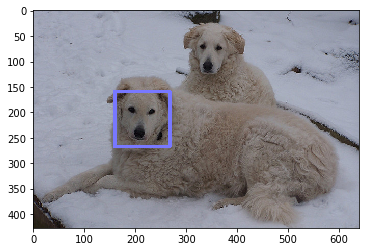

Number of faces detected: 1


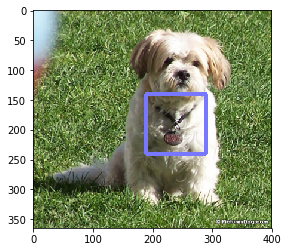

Number of faces detected: 1


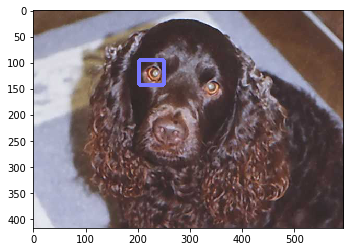

Number of faces detected: 1


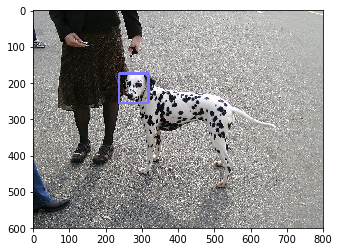

Number of faces detected: 1


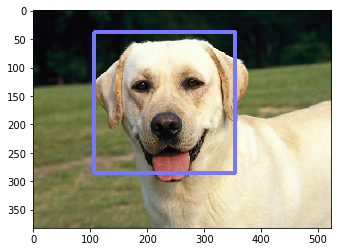

Number of faces detected: 1


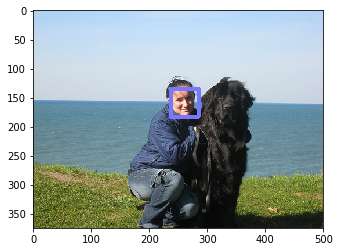

Number of faces detected: 1


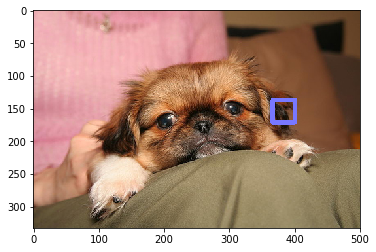

Number of faces detected: 1


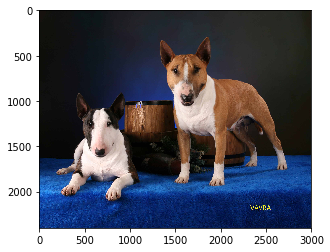

Number of faces detected: 1


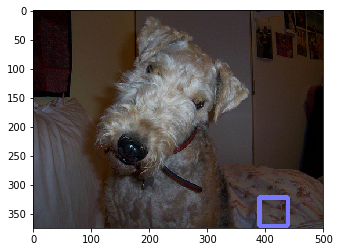

Number of faces detected: 1


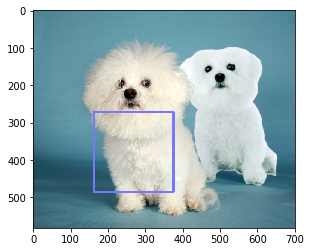

Number of faces detected: 1


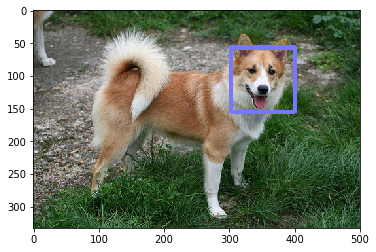

In [14]:
#here we plot and boxe faces in wrong faces human detection.
for d in dog_human_faces:
    detect_and_box_faces(d)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

In order to not disappoint the user, I would recommand to add a note that the view of a face needs to be clear so that users may not get frustrated. Also, it would be possible to detect human faces with CNN that is trained with many human images with different angles.
Nevertheless, we can create as much as possible, a specific CNN to detect humans.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [16]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [32]:
from keras.preprocessing import image 

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [33]:
image

<module 'keras.preprocessing.image' from '/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py'>

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [34]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

     151: 'Chihuahua', 152: 'Japanese spaniel',    153: 'Maltese dog, Maltese terrier, Maltese', 
     154: 'Pekinese, Pekingese, Peke',   155: 'Shih-Tzu', 156: 'Blenheim spaniel', 157: 'papillon', 
     158: 'toy terrier', 159: 'Rhodesian ridgeback', 160: 'Afghan hound, Afghan', 161: 'basset, basset hound',
     162: 'beagle', 163: 'bloodhound, sleuthhound', 164: 'bluetick', 165: 'black-and-tan coonhound',
     166: 'Walker hound, Walker foxhound', 167: 'English foxhound', 168: 'redbone', 169: 'borzoi, Russian wolfhound',
     170: 'Irish wolfhound', 171: 'Italian greyhound', 172: 'whippet', 173: 'Ibizan hound, Ibizan Podenco',
     174: 'Norwegian elkhound, elkhound', 175: 'otterhound, otter hound', 176: 'Saluki, gazelle hound',
     177: 'Scottish deerhound, deerhound', 178: 'Weimaraner', 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
     180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
     181: 'Bedlington terrier', 182: 'Border terrier', 183: 'Kerry blue terrier', 184: 'Irish terrier',
     185: 'Norfolk terrier', 186: 'Norwich terrier', 187: 'Yorkshire terrier', 188: 'wire-haired fox terrier',
     189: 'Lakeland terrier', 190: 'Sealyham terrier, Sealyham', 191: 'Airedale, Airedale terrier',
     192: 'cairn, cairn terrier', 193: 'Australian terrier', 194: 'Dandie Dinmont, Dandie Dinmont terrier',
     195: 'Boston bull, Boston terrier', 196: 'miniature schnauzer', 197: 'giant schnauzer', 198: 'standard schnauzer',
     199: 'Scotch terrier, Scottish terrier, Scottie', 200: 'Tibetan terrier, chrysanthemum dog',
     201: 'silky terrier, Sydney silky', 202: 'soft-coated wheaten terrier', 203: 'West Highland white terrier',
     204: 'Lhasa, Lhasa apso', 205: 'flat-coated retriever', 206: 'curly-coated retriever',
     207: 'golden retriever', 208: 'Labrador retriever', 209: 'Chesapeake Bay retriever', 210: 'German short-haired pointer',
     211: 'vizsla, Hungarian pointer', 212: 'English setter', 213: 'Irish setter, red setter',  214: 'Gordon setter', 
     215: Brittany spaniel', 216: 'clumber, clumber spaniel', 217: 'English springer, English springer spaniel',
     218: 'Welsh springer spaniel', 219: 'cocker spaniel, English cocker spaniel, cocker', 220: 'Sussex spaniel',
     221: 'Irish water spaniel', 222: 'kuvasz', 223: 'schipperke', 224: 'groenendael', 225: 'malinois',
     226: 'briard', 227: 'kelpie', 228: 'komondor', 229: 'Old English sheepdog, bobtail',
     230: 'Shetland sheepdog, Shetland sheep dog, Shetland', 231: 'collie', 232: 'Border collie',
     233: 'Bouvier des Flandres, Bouviers des Flandres', 234: 'Rottweiler',
     235: 'German shepherd, German shepherd dog, German police dog, alsatian', 236: 'Doberman, Doberman pinscher',
     237: 'miniature pinscher', 238: 'Greater Swiss Mountain dog', 239: 'Bernese mountain dog',
     240: 'Appenzeller', 241: 'EntleBucher', 242: 'boxer', 243: 'bull mastiff',
     244: 'Tibetan mastiff', 245: 'French bulldog', 246: 'Great Dane', 247: 'Saint Bernard, St Bernard',
     248: 'Eskimo dog, husky', 249: 'malamute, malemute, Alaskan malamute', 250: 'Siberian husky',
     251: 'dalmatian, coach dog, carriage dog', 252: 'affenpinscher, monkey pinscher, monkey dog', 253: 'basenji',
     254: 'pug, pug-dog', 255: 'Leonberg', 256: 'Newfoundland, Newfoundland dog', 257: 'Great Pyrenees',
     258: 'Samoyed, Samoyede', 259: 'Pomeranian', 260: 'chow, chow chow', 261: 'keeshond',
     262: 'Brabancon griffon', 263: 'Pembroke, Pembroke Welsh corgi', 264: 'Cardigan, Cardigan Welsh corgi',
     265: 'toy poodle', 266: 'miniature poodle', 267: 'standard poodle', 268: 'Mexican hairless',

In [35]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [36]:
predict_ = ResNet50_predict_labels(human_files_short[99])


Number of faces detected: 1


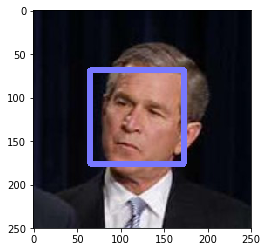

In [37]:
detect_and_box_faces(human_files_short[99], detect=True)

In [38]:
#906 is 906: 'Windsor tie'
predict_


906

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [39]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_detector_performance(image_set):
    '''
    give the performance of dog_detector for an image set
    take an image set as an input
    give a percent as an output
    '''
    
    # count face numbers
    image_count=0
    for im_se in image_set:
        if dog_detector(im_se) == True:
            image_count+=1
    
    # calcul performance
    performance = (float(image_count)/float(len(image_set)))*100
    
    # express performance 
    print('Percent of dogs detected is: {}%'.format(performance))

In [40]:
# dog detector performance on human_files_short
dog_detector_performance(human_files_short)

Percent of dogs detected is: 0.0%


In [41]:
# dog detector performance on dog_files_short
dog_detector_performance(dog_files_short)

Percent of dogs detected is: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [42]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 107.01it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
I decided to take inspiration of a classic CNN model from the keras team, https://github.com/keras-team/keras/tree/master/examples.

I added a batch normalisation to use much higher learning rates and be less careful about initialization (Source: https://arxiv.org/abs/1502.03167).

I also set up a dropout to prevent overfitting.

In [46]:
# inspiration
#https://keras.io/getting-started/sequential-model-guide/
#https://keras.io/models/sequential/
#https://github.com/keras-team/keras/tree/master/examples
# Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, 
# and Techniques to Build Intelligent Systems (Emplacement du Kindle 8614). O'Reilly Media. Édition du Kindle. 
# the Sequential model is a linear stack of layers.
model = Sequential()

model.add(BatchNormalization(input_shape=(224, 224, 3))) 

model.add(Conv2D(16, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(133)) 
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(133)) 
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
activation_50 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      4640      
_________________________________________________________________
activation_51 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
__________

### Compile the Model

In [47]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [20]:
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 103s 15ms/step - loss: 13.1958 - acc: 0.0076 - val_loss: 4.8869 - val_acc: 0.0060
Epoch 2/50
6680/6680 [==============================] - 101s 15ms/step - loss: 4.8967 - acc: 0.0111 - val_loss: 4.8751 - val_acc: 0.0132
Epoch 3/50
6680/6680 [==============================] - 101s 15ms/step - loss: 4.8511 - acc: 0.0117 - val_loss: 4.7461 - val_acc: 0.0347
Epoch 4/50
6680/6680 [==============================] - 101s 15ms/step - loss: 4.6370 - acc: 0.0347 - val_loss: 4.5552 - val_acc: 0.0359
Epoch 5/50
6680/6680 [==============================] - 101s 15ms/step - loss: 4.3620 - acc: 0.0533 - val_loss: 4.4883 - val_acc: 0.0419
Epoch 6/50
6680/6680 [==============================] - 101s 15ms/step - loss: 4.0130 - acc: 0.1043 - val_loss: 4.3897 - val_acc: 0.0539
Epoch 7/50
6680/6680 [==============================] - 100s 15ms/step - loss: 3.6065 - acc: 0.1564 - val_loss: 4.8666 - val_acc: 

Epoch 31/50
6680/6680 [==============================] - 101s 15ms/step - loss: 0.8767 - acc: 0.7787 - val_loss: 9.3788 - val_acc: 0.0731
Epoch 32/50
6680/6680 [==============================] - 101s 15ms/step - loss: 0.8337 - acc: 0.7846 - val_loss: 6.3810 - val_acc: 0.0563
Epoch 33/50
6680/6680 [==============================] - 100s 15ms/step - loss: 0.8334 - acc: 0.7885 - val_loss: 9.0924 - val_acc: 0.0623
Epoch 34/50
6680/6680 [==============================] - 100s 15ms/step - loss: 0.8093 - acc: 0.7985 - val_loss: 7.9371 - val_acc: 0.0719
Epoch 35/50
6680/6680 [==============================] - 100s 15ms/step - loss: 0.8481 - acc: 0.7880 - val_loss: 9.0675 - val_acc: 0.0575
Epoch 36/50
6680/6680 [==============================] - 101s 15ms/step - loss: 0.8050 - acc: 0.7913 - val_loss: 8.3761 - val_acc: 0.0611
Epoch 37/50
6680/6680 [==============================] - 100s 15ms/step - loss: 0.8503 - acc: 0.7861 - val_loss: 8.3503 - val_acc: 0.0599
Epoch 38/50
6680/6680 [===========

### Load the Model with the Best Validation Loss

In [48]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [49]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.7416%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [50]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [51]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [52]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [77]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s 765us/step - loss: 12.8585 - acc: 0.1016 - val_loss: 11.5281 - val_acc: 0.1760
Epoch 2/20
6680/6680 [==============================] - 2s 337us/step - loss: 10.6590 - acc: 0.2537 - val_loss: 10.5024 - val_acc: 0.2659
Epoch 3/20
6680/6680 [==============================] - 2s 363us/step - loss: 10.1030 - acc: 0.3234 - val_loss: 10.3551 - val_acc: 0.2814
Epoch 4/20
6680/6680 [==============================] - 2s 339us/step - loss: 9.9620 - acc: 0.3497 - val_loss: 10.1501 - val_acc: 0.3114
Epoch 5/20
6680/6680 [==============================] - 2s 335us/step - loss: 9.8300 - acc: 0.3638 - val_loss: 10.1136 - val_acc: 0.3186
Epoch 6/20
6680/6680 [==============================] - 2s 349us/step - loss: 9.7456 - acc: 0.3790 - val_loss: 9.9816 - val_acc: 0.3305
Epoch 7/20
6680/6680 [==============================] - 2s 335us/step - loss: 9.4536 - acc: 0.3949 - val_loss: 9.7192 - val_acc: 

### Load the Model with the Best Validation Loss

In [53]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [54]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.2249%


### Predict Dog Breed with the Model

In [56]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return short_dog_names[np.argmax(predicted_vector)]


In [57]:
print('VGG16_predict_breed predict image \n\r American_water_spaniel_00648 as {} \n\r and Labrador_retriever_06457 as {}'\
      .format(VGG16_predict_breed('images/American_water_spaniel_00648.jpg'), \
              VGG16_predict_breed('images/Labrador_retriever_06457.jpg')))


VGG16_predict_breed predict image 
 American_water_spaniel_00648 as 068.Flat-coated_retriever 
 and Labrador_retriever_06457 as 096.Labrador_retriever


Number of faces detected: 0


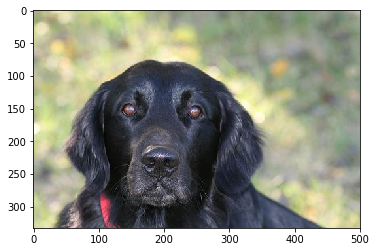

In [66]:
detect_and_box_faces('../../../data/dog_images/train/068.Flat-coated_retriever/Flat-coated_retriever_04687.jpg')

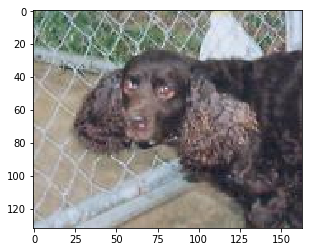

In [67]:
detect_and_box_faces('../../../data/dog_images/train/009.American_water_spaniel/American_water_spaniel_00622.jpg', False)

Test accuracy is only 42% so, prediction is 1 over 2 right

American water spaniel is hard to predict.

Flat coated retriever and amercian water spaniel are closed and not easy to identify properly.

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [43]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I use a pre-trained network ResNet50.

I add at our sequential model:

- `GlobalAveragePooling` gives the Global average pooling operation for spatial data
- `Dense` to link the features to the 133 dog breed classes
- `softmax` activate for mulit class classification



In [44]:
### TODO: Define your architecture.
Resnet50_model = Sequential()

Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:])) 
Resnet50_model.add(Dense(133)) 
Resnet50_model.add(Activation('softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
_________________________________________________________________
activation_50 (Activation)   (None, 133)               0         
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [45]:
### Compile the model.
Resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [37]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=50, batch_size=60, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 1s 174us/step - loss: 2.1012 - acc: 0.5337 - val_loss: 0.9684 - val_acc: 0.7234
Epoch 2/50
6680/6680 [==============================] - 1s 107us/step - loss: 0.5099 - acc: 0.8808 - val_loss: 0.7192 - val_acc: 0.7868
Epoch 3/50
6680/6680 [==============================] - 1s 106us/step - loss: 0.2759 - acc: 0.9497 - val_loss: 0.6313 - val_acc: 0.8168
Epoch 4/50
6680/6680 [==============================] - 1s 104us/step - loss: 0.1704 - acc: 0.9772 - val_loss: 0.6055 - val_acc: 0.8036
Epoch 5/50
6680/6680 [==============================] - 1s 116us/step - loss: 0.1146 - acc: 0.9916 - val_loss: 0.5718 - val_acc: 0.8251
Epoch 6/50
6680/6680 [==============================] - 1s 104us/step - loss: 0.0818 - acc: 0.9970 - val_loss: 0.5533 - val_acc: 0.8263
Epoch 7/50
6680/6680 [==============================] - 1s 104us/step - loss: 0.0633 - acc: 0.9978 - val_loss: 0.5529 - val_acc: 0.8275
E

Epoch 30/50
6680/6680 [==============================] - 1s 103us/step - loss: 0.0083 - acc: 0.9987 - val_loss: 0.5813 - val_acc: 0.8395
Epoch 31/50
6680/6680 [==============================] - 1s 114us/step - loss: 0.0102 - acc: 0.9985 - val_loss: 0.5993 - val_acc: 0.8431
Epoch 32/50
6680/6680 [==============================] - 1s 115us/step - loss: 0.0100 - acc: 0.9985 - val_loss: 0.5730 - val_acc: 0.8383
Epoch 33/50
6680/6680 [==============================] - 1s 114us/step - loss: 0.0086 - acc: 0.9985 - val_loss: 0.5907 - val_acc: 0.8419
Epoch 34/50
6680/6680 [==============================] - 1s 106us/step - loss: 0.0069 - acc: 0.9988 - val_loss: 0.5905 - val_acc: 0.8419
Epoch 35/50
6680/6680 [==============================] - 1s 107us/step - loss: 0.0086 - acc: 0.9985 - val_loss: 0.6068 - val_acc: 0.8347
Epoch 36/50
6680/6680 [==============================] - 1s 103us/step - loss: 0.0079 - acc: 0.9987 - val_loss: 0.6248 - val_acc: 0.8335
Epoch 37/50
6680/6680 [==================

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [46]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [47]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


In [48]:
print(classification_report([np.argmax(x) for x in test_targets], Resnet50_predictions, target_names = short_dog_names))

                                        precision    recall  f1-score   support

                     001.Affenpinscher       1.00      0.75      0.86         8
                      002.Afghan_hound       1.00      0.75      0.86         8
                  003.Airedale_terrier       0.71      0.83      0.77         6
                             004.Akita       1.00      0.88      0.93         8
                  005.Alaskan_malamute       0.91      1.00      0.95        10
               006.American_eskimo_dog       1.00      1.00      1.00         8
                 007.American_foxhound       0.71      0.71      0.71         7
    008.American_staffordshire_terrier       0.80      1.00      0.89         8
            009.American_water_spaniel       0.67      0.50      0.57         4
            010.Anatolian_shepherd_dog       0.71      0.83      0.77         6
             011.Australian_cattle_dog       1.00      0.89      0.94         9
               012.Australian_shepherd 

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [49]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return short_dog_names[np.argmax(predicted_vector)]



In [50]:
predict_breed('images/American_water_spaniel_00648.jpg')

94658560/94653016 [==============================] - 3s 0us/step


'035.Boykin_spaniel'

In [65]:
print('predict_breed with Resnet50 predict image \n\r American_water_spaniel_00648 as {} \n\r and Labrador_retriever_06457 as {}'\
      .format(predict_breed('images/American_water_spaniel_00648.jpg'), \
              predict_breed('images/Labrador_retriever_06457.jpg')))

predict_breed with Resnet50 predict image 
 American_water_spaniel_00648 as 035.Boykin_spaniel 
 and Labrador_retriever_06457 as 096.Labrador_retriever


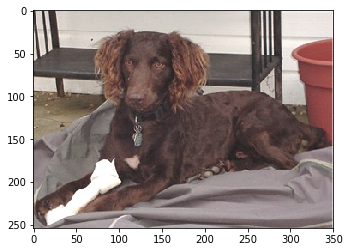

In [71]:
detect_and_box_faces('../../../data/dog_images/train/035.Boykin_spaniel/Boykin_spaniel_02446.jpg', False)

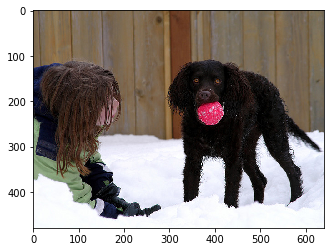

In [76]:
detect_and_box_faces('../../../data/dog_images/train/009.American_water_spaniel/American_water_spaniel_00629.jpg', False)

The Test accuracy is 83%, it's great. Not good enough to predict correctly American Water Spaniel

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [51]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def breed_detector(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path):
        print('Hello dog! You look like a ....')
        return predict_breed(img_path)
    elif face_detector(img_path):
        print('Hello human! You look like a ....')
        return predict_breed(img_path)
        
    else:
        print('error: we do not detect in the image a dog nor a man')
        return 'error: we do not detect in the image a dog nor a man'

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Hello dog! You look like a ....


'035.Boykin_spaniel'

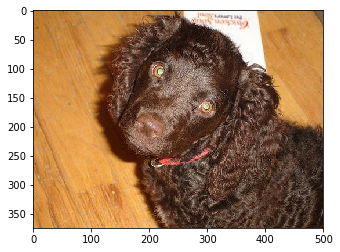

In [52]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
breed_detector('images/American_water_spaniel_00648.jpg')


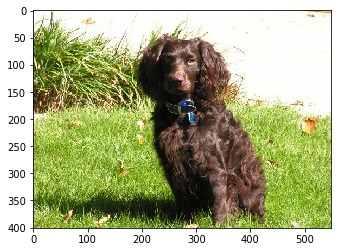

In [80]:
detect_and_box_faces('../../../data/dog_images/train/035.Boykin_spaniel/Boykin_spaniel_02440.jpg', False)

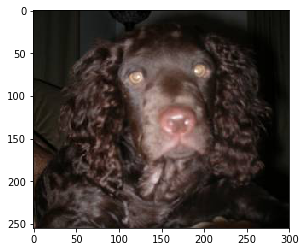

In [81]:
detect_and_box_faces('../../../data/dog_images/train/009.American_water_spaniel/American_water_spaniel_00623.jpg', False)

Hello dog! You look like a ....


'037.Brittany'

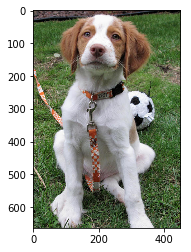

In [82]:
breed_detector('images/Brittany_02625.jpg')


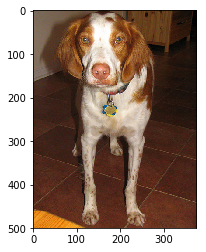

In [84]:
detect_and_box_faces('../../../data/dog_images/train/037.Brittany/Brittany_02595.jpg', False)

Hello dog! You look like a ....


'055.Curly-coated_retriever'

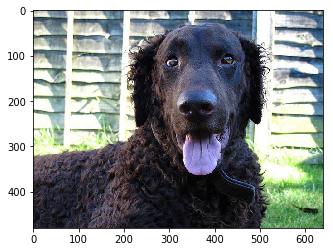

In [85]:
breed_detector('images/Curly-coated_retriever_03896.jpg')

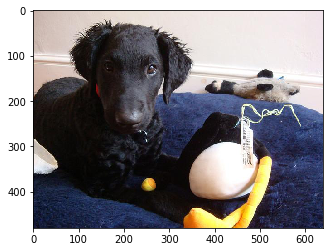

In [86]:
detect_and_box_faces('../../../data/dog_images/train/055.Curly-coated_retriever/Curly-coated_retriever_03861.jpg', False)

Hello dog! You look like a ....


'096.Labrador_retriever'

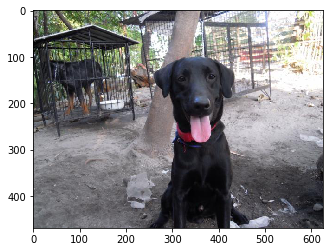

In [87]:
breed_detector('images/Labrador_retriever_06449.jpg')

Hello dog! You look like a ....


'096.Labrador_retriever'

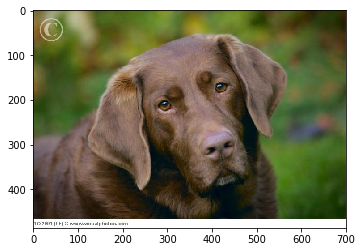

In [88]:
breed_detector('images/Labrador_retriever_06455.jpg')

Hello dog! You look like a ....


'096.Labrador_retriever'

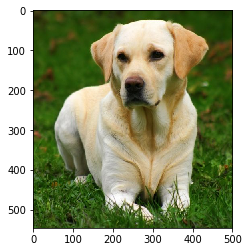

In [89]:
breed_detector('images/Labrador_retriever_06457.jpg')


Hello dog! You look like a ....


'130.Welsh_springer_spaniel'

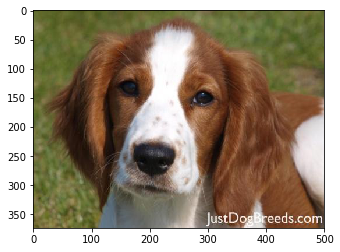

In [90]:
breed_detector('images/Welsh_springer_spaniel_08203.jpg')

Hello dog! You look like a ....


'095.Kuvasz'

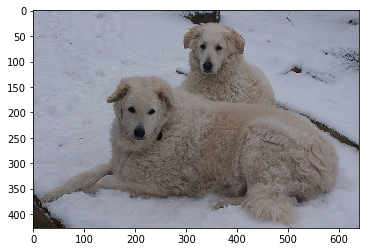

In [91]:
breed_detector('../../../data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg')

Hello human! You look like a ....


'056.Dachshund'

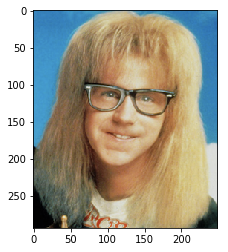

In [91]:
breed_detector('images/sample_human_2.png')

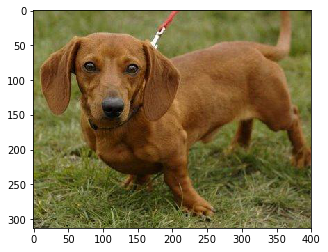

In [104]:
detect_and_box_faces('../../../data/dog_images/train/056.Dachshund/Dachshund_03922.jpg', False)

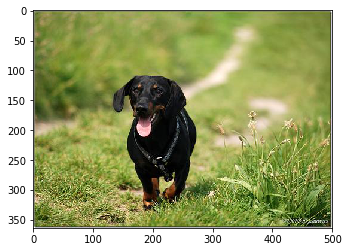

In [103]:
detect_and_box_faces('../../../data/dog_images/train/056.Dachshund/Dachshund_03923.jpg', False)

Number of faces detected: 0


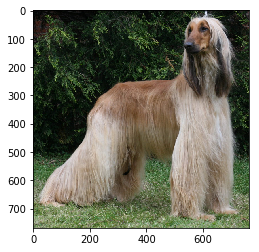

In [100]:
detect_and_box_faces('../../../data/dog_images/train/002.Afghan_hound/Afghan_hound_00081.jpg')

Hello human! You look like a ....


'071.German_shepherd_dog'

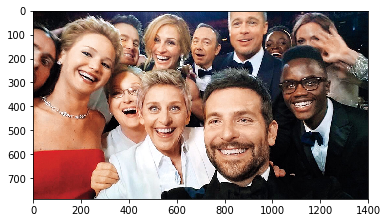

In [94]:
breed_detector('images/1_FQz-iuc3Y2f6Cnvnx0chlw.jpeg')

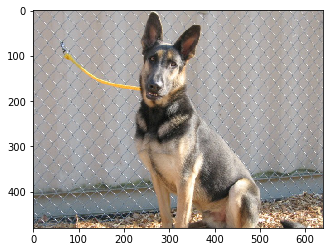

In [114]:
detect_and_box_faces('../../../data/dog_images/train/071.German_shepherd_dog/German_shepherd_dog_04887.jpg', False)

Number of faces detected: 9


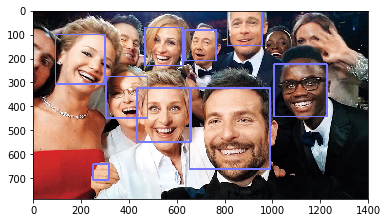

In [95]:
detect_and_box_faces('images/1_FQz-iuc3Y2f6Cnvnx0chlw.jpeg')

error: we do not detect in the image a dog nor a man


'error: we do not detect in the image a dog nor a man'

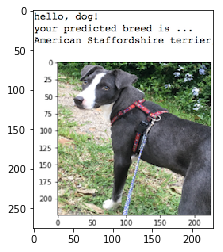

In [96]:
breed_detector('images/sample_dog_output.png')

Hello human! You look like a ....


'110.Norwegian_lundehund'

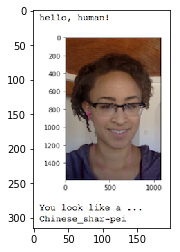

In [97]:
breed_detector('images/sample_human_output.png')

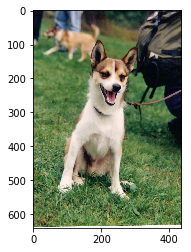

In [102]:
detect_and_box_faces('../../../data/dog_images/train/110.Norwegian_lundehund/Norwegian_lundehund_07187.jpg', False)

Hello human! You look like a ....


'069.French_bulldog'

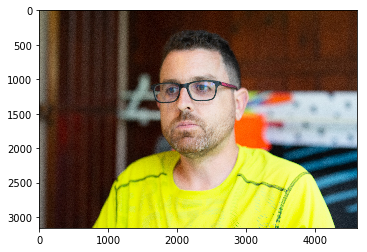

In [105]:
breed_detector('images/1V6A2836.jpeg')

Number of faces detected: 0


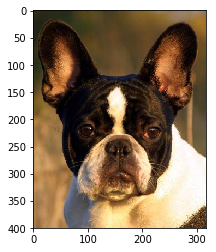

In [98]:
detect_and_box_faces('../../../data/dog_images/train/069.French_bulldog/French_bulldog_04765.jpg')

Number of faces detected: 1


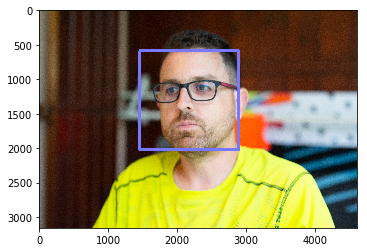

In [109]:
detect_and_box_faces('images/1V6A2836.jpeg', box_thick=40)

Hello human! You look like a ....


'069.French_bulldog'

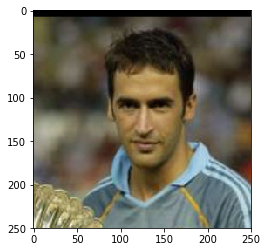

In [111]:
breed_detector(human_files[131])

Hello human! You look like a ....


'127.Silky_terrier'

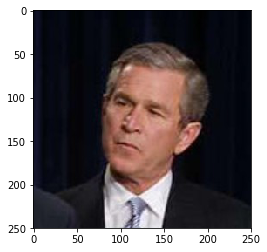

In [112]:
breed_detector(human_files_short[99])

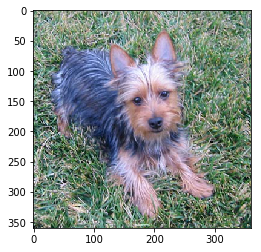

In [113]:
detect_and_box_faces('../../../data/dog_images/train/127.Silky_terrier/Silky_terrier_08042.jpg', False)

Hello human! You look like a ....


'127.Silky_terrier'

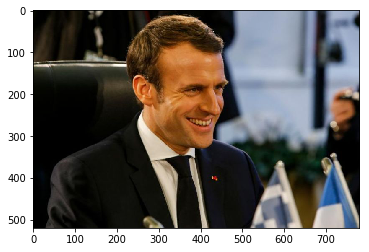

In [115]:
breed_detector('images/hzmacron0201.jpg')

Hello human! You look like a ....


'002.Afghan_hound'

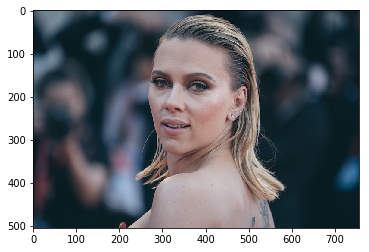

In [116]:
breed_detector('images/Scarlett-Johansson.jpg')

Hello human! You look like a ....


'016.Beagle'

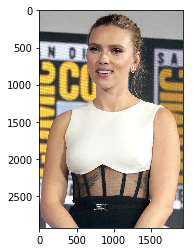

In [117]:
breed_detector('images/Scarlett_Johansson_by_Gage_Skidmore_2_(cropped).jpg')

Hello human! You look like a ....


'056.Dachshund'

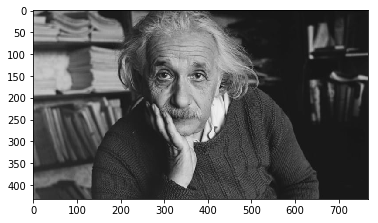

In [119]:
breed_detector('images/albert-einstein.jpg')

Hello human! You look like a ....


'124.Poodle'

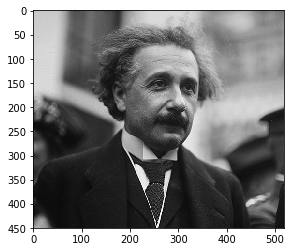

In [120]:
breed_detector('images/albert_einstein.jpg')

### Explanation of Testing of the Algorithm

 

| Image                        | Expected                      | Predict                   | Comment                       |
|:----------------------------:|:-----------------------------:|--------------------------:|:-----------------------------:|
| American_water_spaniel_00648 | dog - American Water Spaniel  |  dog - 035.Boykin_spaniel | Wrong prediction but close    |
| Brittany_02625               | dog - Brittany                |  dog - 037.Brittany       | Right                         |
| Curly-coated_retriever_03896 | dog - Curly coated Retriever  |  dog - 055.Curly_Coated_Re| Right                         |
| Labrador_retriever_06449     | dog - Labrador Retriever      |  dog - 096.Labrador_Retr  | Right                         |
| Labrador_retriever_06455     | dog - Labrador Retriever      |  dog - 096.Labrador_Retr  | Right                         |
| Labrador_retriever_06457     | dog - Labrador Retriever      |  dog - 096.Labrador_Retr  | Right                         |
| Welsh_springer_spaniel_08203 | dog - Welsh Springer Spaniel  |  dog - 130.Welsh_spring_Sp| Right, again                  |
| Kuvasz_06442                 | dog - Kuvasz                  |  dog - 095.Kuvasz         | Right                         |
| sample_human_2               | human - 002.Afghan Hound      |  human - 056.Dachshund    | Human but would prefer Afghan |
|                              |                               |                           | Hound, Dashund not so close   |
| sample_human_output          | human - ??                    | human - 110.Norwegian_lu  | Wrong, seems not so close     |
| 1_FQz-iuc3Y2f6Cnvnx0chlw     | human - ??                    | human - 071.German_shephe |
| 1V6A2836                     | human - ??                    | human - 069.French_bulldog| myself, human detection ok    |
| human_files[131]             | human - ??                    | human - 069.French_bulldog| Raul, human detection ok      |
| human_files_short[99]        | human - ??                    | human - 127.Silky_terrier | GW Bush, human detection ok   |
| hzmacron0201                 | human - ??                    | human - 127.Silky_terrier | E Macron                      |
| Scarlett-Johansson           | human - ??                    | human - 002.Afghan_hound  | Scarlett Johansson            |
| Scarlett_Johansson_by_Gage   | human - ??                    | human - 016.Beagle        | Scarlett Johansson            |
| albert-einstein              | human - ??                    | human - 056.Dachshund     | Albert Einstein               |
| albert_einstein              | human - ??                    | human - 124.Poodle        | Albert Einstein               |


This was interesting to see the results at the end of the experiement. A brief description of my views are below...

With Resnet50_predictions, the test accruracy is 83%. This looks great, but may be not good enough to predict difficult breed like American Water Spaniel.

The detection Human vs dog works perfectly.

About association of human faces with dog breed, I'm not certain that's correct.

For me, to be compared to French Bulldog look offensive. Right I'm french, but bulldog ! 

Nevertheless, I'm glad to be classified as Raùl like a french bulldog.

About GW Bush, classified as human, ok, but Silky Terrier, not sure it's right.
What is awesome, it's the fact that E Macron, French president is also predicted as Silky Terrier. May be Nation President are all predicted as Silky Terrier !

For the image 1_FQz-iuc3Y2f6Cnvnx0chlw with 9 faces detected, it's not appropriate, because we don't know witch faces is predicted as 071.German Sheperd; may be Bradley Cooper ! The image to predict breed shall contains only one faces. May be should be good to modify breed_detector function in order to detect that if more than 1 face is detected, prediction should be wrong.

By using two different pictures of Scarlett Johansson, with two different hair dresses, the prediction is different. But, at least, I can understand why.

The same think happens for the different representation of Albert Einstein, predicted as Dashund and Poodle, depending of the hair dresses and the context of the pictures.

To improve the algorithm I could:

- give more training time and more training data to our algorithm.
- explored other models and do some iteration when fine tuning.
- get a percentage from breed probabilities.


In [121]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'dog_app.ipynb'])

0